In [26]:
# y -> outlet liquid temperature
# q(t) -> liquid flow rate
# Narx -> yhat(t+1|t) = f(y(t) ... y(t-3) u(t) ... u(t-9))

#read data
data = open('../exchanger/exchanger.dat')
lst = []
for line in data:
    lst += [line.split()]
time = [float(x[0]) for x in lst]
u = [float(x[1]) for x in lst]
y = [float(x[2]) for x in lst]

In [27]:
#divide identification set and validation set
ID_LENGHT = 3000
time_id = time[:ID_LENGHT]
u_id = u[:ID_LENGHT]
y_id = y[:ID_LENGHT]

time_val = time[ID_LENGHT:]
u_val = u[ID_LENGHT:]
y_val = y[ID_LENGHT:]

In [28]:
def generateInput():
        input1= list()
        for i in range(500):
            if(i%2==0):
                input1.append(0.5)
            else:
                input1.append(-0.5)
        return input1

def generateOutput(inputx):
    reg = [0,0,0,0,0,0]
    outputx = list()
    for i in range(500):
        y = 0.3 * reg[0] + 0.5 * np.power(reg[3],2) * reg[0] - 1 * np.power(reg[5],2)
        outputx.append(y)
        if (i-1 >= 0):
            reg[0] = inputx[i -1]
            reg[3] = outputx[i -1]
        if (i-2 >= 0):
            reg[1] = inputx[i -2]
            reg[4] = outputx[i -2]
        if (i-3 >= 0):
            reg[2] = inputx[i -3]
            reg[5] = outputx[i -3]
    return outputx

In [38]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

poly_degree = 1

features = ['u(t-9)', 'u(t-8)', 'u(t-7)', 'u(t-6)', 'u(t-5)', 'u(t-4)', 'u(t-3)', 'u(t-2)', 'u(t-1)', 'u(t)',\
                'y(t-3)', 'y(t-2)', 'y(t-1)', 'y(t)']

poly = PolynomialFeatures(poly_degree)

In [39]:
u_id = generateInput()
y_id = generateOutput(u_id)

In [40]:
Y = np.array(y_id[10:len(y_id)])
PHI = []
for i in tqdm(range(500 - 10)):
    regressors = [u_id[i:i+10] + y_id[6+i:10+i]]
    PHI.append(poly.fit_transform(regressors)[0])
PHI = np.array(PHI)
regressor_terms = poly.get_feature_names(features)

100%|██████████████████████████████████████████████████████████████████████████████| 490/490 [00:00<00:00, 3475.16it/s]


In [41]:
#FROE Implementation

A = np.zeros((PHI.shape[1],PHI.shape[1]))
W = np.zeros(PHI.shape)
g_hat = np.array([])
np.fill_diagonal(A,1)
regressor_selected = np.array([], dtype=int)
err_sum = 0
threshold = 0.052
    
for k in range(PHI.shape[1]):
    err = np.array([])
    g = np.array([])
    if k == 0:
        for i in range(PHI.shape[1]):
            W[:,0] = PHI[:,i]
            g_i = np.dot(W[:,0],Y)/np.power(np.linalg.norm(W[:,0]),2)
            g = np.append(g, g_i)
            err_i = np.power(g_i,2) *  np.power(np.linalg.norm(W[:,0]),2) / np.power(np.linalg.norm(Y),2)
            err = np.append(err, err_i)
        j = np.argmax(err)
        print(regressor_terms[j])
        W[:,0] = PHI[:,j]
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        err_sum += err[j]
        if (1-err_sum < threshold):
            print('Threshold exceeded!')
            break;
    else:
        for l in range(PHI.shape[1]):
            if l not in regressor_selected:
                temp = np.zeros(PHI.shape[0])
                for i in range(k):
                    A[i,k] = (np.dot(W[:,i],PHI[:,l]))/np.power(np.linalg.norm(W[:,i]),2)
                    temp += A[i,k] * W[:,i]
                W[:,k] = PHI[:,l] - temp
                #g = np.append(g, (np.dot(W[:,k],Y))/np.power(np.linalg.norm(W[:,k]),2))
                g_i = np.dot(W[:,k],Y)/np.power(np.linalg.norm(W[:,k]),2)
                g = np.append(g, g_i)
                err_i = np.power(g_i,2) *  np.power(np.linalg.norm(W[:,k]),2) / np.power(np.linalg.norm(Y),2)
                err = np.append(err, err_i)
            else:
                err = np.append(err, 0)
                g = np.append(g, 0)
        j = np.argmax(err)
        temp = np.zeros(PHI.shape[0])
        for i in range(k):
            A[i,k] = (np.dot(W[:,i],PHI[:,j]))/np.power(np.linalg.norm(W[:,i]),2)
            temp += A[i,k] * W[:,i]
        print(regressor_terms[j])
        W[:,k] = PHI[:,j] - temp
        g_hat = np.append(g_hat, g[j])
        regressor_selected = np.append(regressor_selected, j)
        err_sum += err[j]
        if (1-err_sum < threshold):
            print('Threshold exceeded!')
            break;
print(g_hat)     
theta = np.zeros(len(g_hat))
for i in reversed(range(len(g_hat))):
    if i == len(g_hat):
        theta[i] = g_hat[i]
    else:
        temp = 0
        for k in range(i+1, len(g_hat)):
            temp += A[i,k] * theta[k]
        theta[i] = g_hat[i] - temp

y(t-1)
Threshold exceeded!
[ 1.00028793]


In [42]:
PHI_final = np.zeros((PHI.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final[:,i] = PHI[:, regressor_selected[i]]

In [43]:
y_hat = np.dot(PHI_final, theta)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


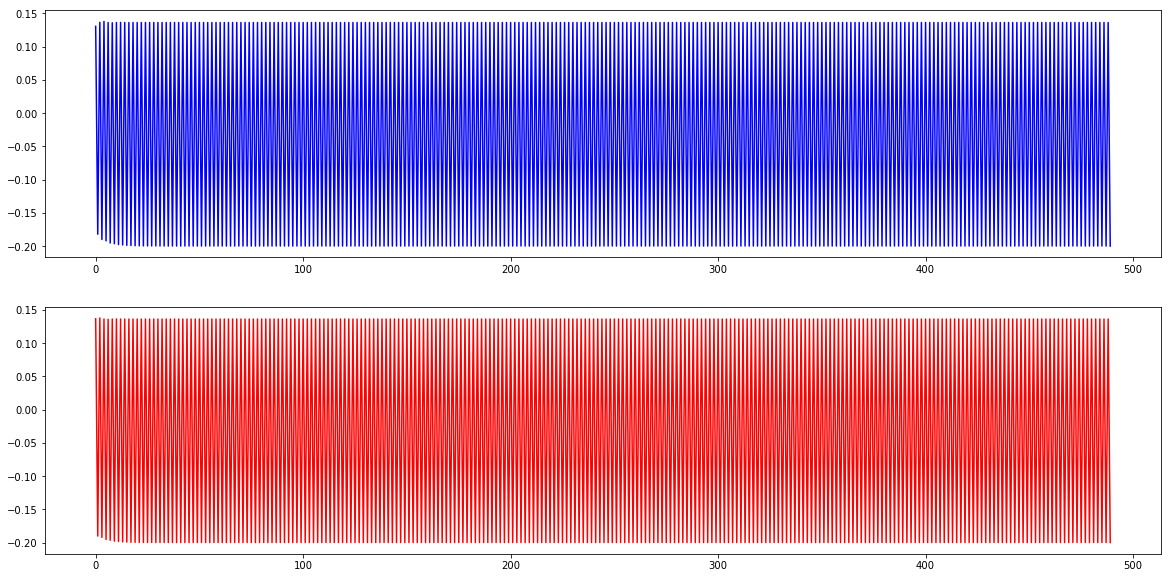

In [44]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

plt.subplot(211)
plt.plot(y_hat[:2990], color='blue')
plt.subplot(212)
plt.plot(y_id[10:3000], color='red')
plt.show()

In [53]:
from sklearn.metrics import mean_squared_error
MSE_id = mean_squared_error(y_id[10:],y_hat)
MSE_id

2.5149300650426003e-07

In [56]:
#Validation
y_val = y_id
u_val = u_id
Y_val = np.array(y_val[10:len(y_val)])
PHI_val = []
poly = PolynomialFeatures(poly_degree)
for i in range(500-10):
    regressors = [u_val[i:i+10] + y_val[6+i:10+i]]
    PHI_val.append(poly.fit_transform(regressors)[0])
PHI_val = np.array(PHI_val)

In [57]:
PHI_final_val = np.zeros((PHI_val.shape[0], len(regressor_selected)))
for i in range(len(regressor_selected)):
    PHI_final_val[:,i] = PHI_val[:, regressor_selected[i]]

In [58]:
y_hat_val = np.dot(PHI_final_val, theta)

Populating the interactive namespace from numpy and matplotlib


C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


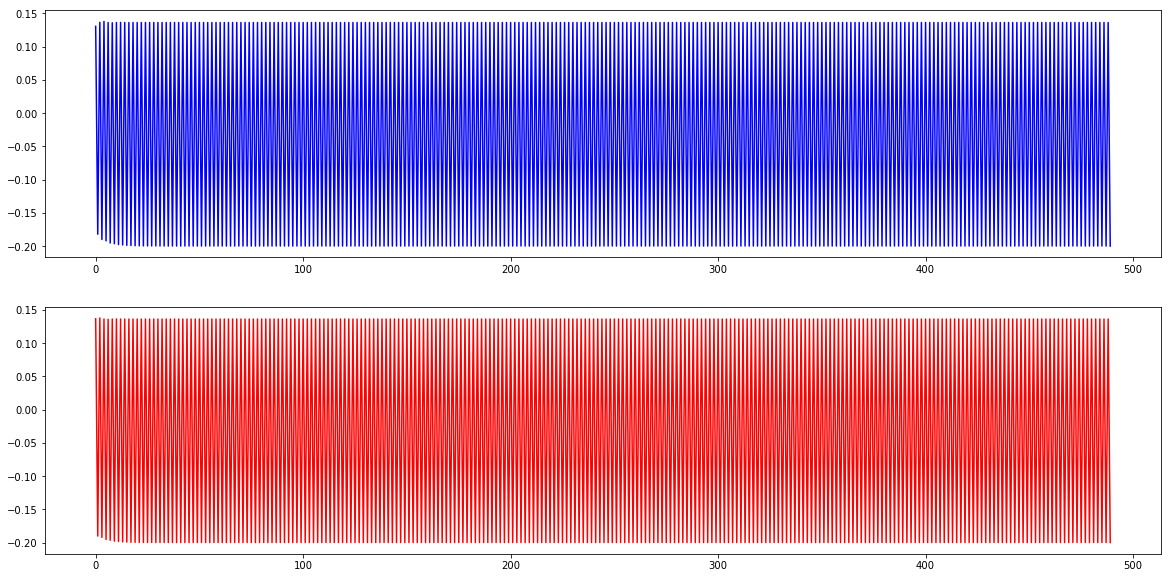

In [59]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

plt.subplot(211)
plt.plot(y_hat_val[:990], color='blue')
plt.subplot(212)
plt.plot(y_val[10:1000], color='red')
plt.show()

In [60]:
MSE_val = mean_squared_error(y_val[10:],y_hat_val)
MSE_val

2.5149300650426003e-07

In [85]:
## Simulation 
# start from initial phi, then build step by step each ne element
poly = PolynomialFeatures(poly_degree)
reg_y = y_val[6:10]
reg = [u_val[:10] + y_val[6:10]]
reg = poly.fit_transform(reg)[0]
len(reg)

15

In [86]:
model_reg = reg[regressor_selected]  # initial values for the regression

In [87]:
regressor_selected
model_reg

array([ 0.13024008])

In [88]:
#simulate the process
y_hat_sim  = []
for i in range(500-10):
    y_i = np.dot(model_reg,theta) #simulated
    y_hat_sim.append(y_i)
    print(y_i)
    reg_u = u_val[i+1:i+1+10]
    reg_y = (reg_y + [y_i])[1:] #append at beggining, then remove last one( [:-1])
    reg = [ reg_u + reg_y]
    reg = poly.fit_transform(reg)[0]
    model_reg = reg[regressor_selected]

0.130277579368
-0.182242051031
0.130315089999
-0.182294523715
0.13035261143
-0.182347011508
0.130390143665
-0.182399514413
0.130427686706
-0.182452032435
0.130465240557
-0.182504565579
0.130502805221
-0.182557113849
0.1305403807
-0.182609677249
0.130577966999
-0.182662255783
0.13061556412
-0.182714849456
0.130653172066
-0.182767458273
0.130690790841
-0.182820082237
0.130728420447
-0.182872721353
0.130766060888
-0.182925375625
0.130803712166
-0.182978045058
0.130841374286
-0.183030729656
0.130879047249
-0.183083429423
0.130916731059
-0.183136144364
0.13095442572
-0.183188874483
0.130992131234
-0.183241619785
0.131029847605
-0.183294380273
0.131067574835
-0.183347155953
0.131105312928
-0.183399946829
0.131143061887
-0.183452752904
0.131180821715
-0.183505574184
0.131218592415
-0.183558410673
0.13125637399
-0.183611262374
0.131294166444
-0.183664129294
0.131331969779
-0.183717011435
0.131369783999
-0.183769908802
0.131407609107
-0.1838228214
0.131445445105
-0.183875749233
0.131483291998
-

Populating the interactive namespace from numpy and matplotlib


C:\Users\Matteo\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['poly']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


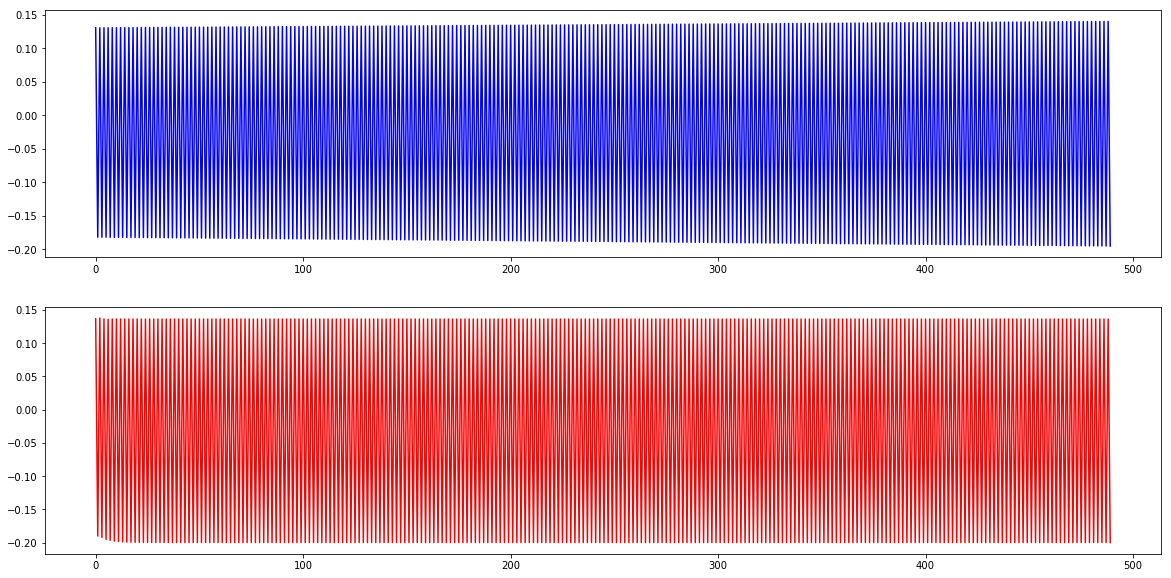

In [90]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

plt.subplot(211)
plt.plot(y_hat_sim[:500], color='blue')
plt.subplot(212)
plt.plot(y_val[10:500], color='red')
plt.show()

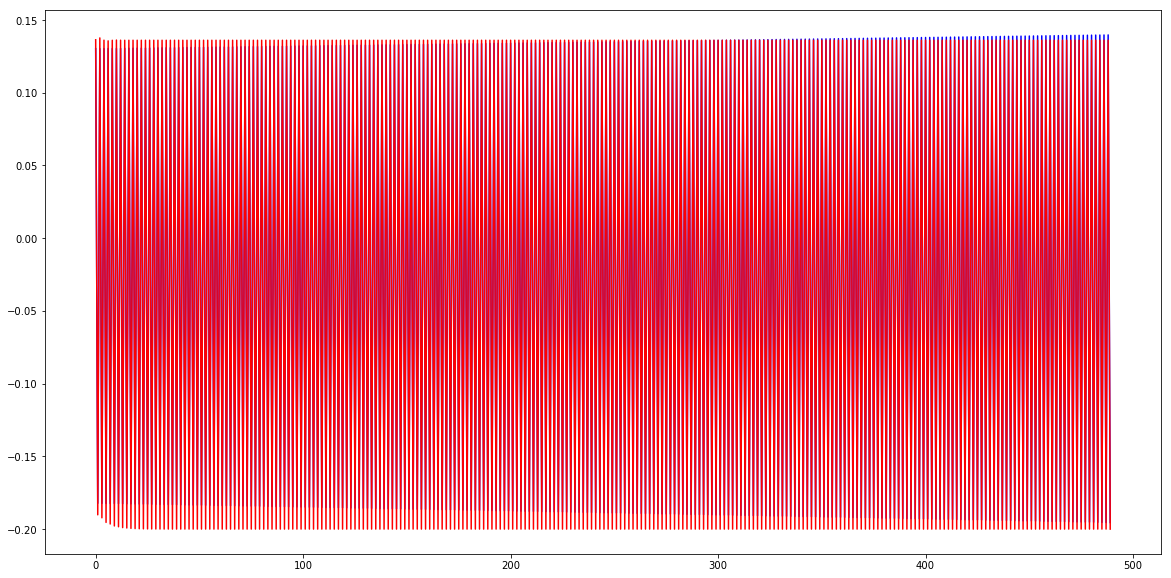

In [91]:
plt.plot(y_hat_sim[:990], color='blue')
plt.plot(y_val[10:1000], color='red')
plt.show()

In [92]:
MSE_sim = mean_squared_error(y_val[10:],y_hat_sim)
MSE_sim

7.2675974488669125e-05